In [1]:
# ============================================
# 0) LIBRARIES & GLOBALS
# ============================================
import os, warnings, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
)
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("✓ Libraries loaded")




✓ Libraries loaded


In [2]:
# ============================================
# 1) LOAD DATA (GOOGLE DRIVE)
# ============================================
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = "/content/drive/MyDrive/AdvMLAT3/processed"
MODEL_DIR = "/content/drive/MyDrive/AdvMLAT3/models"
os.makedirs(MODEL_DIR, exist_ok=True)

DATA_PATH = f"{DATA_DIR}/solana_features_engineered.csv"
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

target_col = "target_high_tomorrow"
print(f"Data loaded: {df.shape}")
print(f"Date range: {df['timestamp'].min().date()} → {df['timestamp'].max().date()}")
assert target_col in df.columns, f"Missing target column `{target_col}` in {DATA_PATH}"



Mounted at /content/drive
Data loaded: (631, 126)
Date range: 2024-02-04 → 2025-10-26


In [3]:
# ============================================
# 2) SAFE FEATURE LIST (PAST-ONLY, ROBUST TO NAMES)
# ============================================
cols = set(df.columns)

def present(*cands):
    """Return the first column name that exists from candidates; else None."""
    for c in cands:
        if c in cols:
            return c
    return None

def present_many(candidates):
    return [c for c in candidates if c in cols]

# LAG ranges
lag_list = [1, 2, 3, 5, 7, 14, 30]

# Build lag features with both naming schemes supported
lag_feats = []
for L in lag_list:
    lag_feats += [
        present(f'open_prev_{L}',  f'open_lag_{L}'),
        present(f'high_prev_{L}',  f'high_lag_{L}'),
        present(f'low_prev_{L}',   f'low_lag_{L}'),
        present(f'close_prev_{L}', f'close_lag_{L}')
    ]
lag_feats = [c for c in lag_feats if c is not None]

# Rolling averages & extremes
roll_feats = []
for W in [7, 14, 30]:
    roll_feats += present_many([
        f'sma_close_{W}', f'ema_close_{W}', f'sma_high_{W}', f'std_close_{W}',
        f'low_min_{W}', f'high_max_{W}'
    ])

# Volatility family (support both naming styles)
vol_feats = present_many([
    'rolling_vol_7d', 'rolling_vol_14d', 'rolling_vol_30d',
    'volatility_7d', 'volatility_14d', 'volatility_30d',
    'atr_7d', 'atr_14d', 'atr_7', 'atr_14',
    'parkinson_vol_30d', 'parkinson_volatility'
])

# Technical indicators
tech_feats = [
    present('rsi_14', 'rsi14'),
    present('rsi_7', 'rsi7'),
    present('macd', 'macd_line'),
    'macd_signal',
    present('macd_hist', 'macd_histogram'),
    'bb_bandwidth', 'bb_percent'
]
tech_feats = [c for c in tech_feats if c is not None]

# Price change / momentum
price_feats = present_many([
    'pct_close_change','pct_high_change','pct_low_change',
    'pct_return_3d','pct_return_7d','pct_return_14d','pct_return_30d',
    'abs_price_shift','abs_price_shift_7d',
    'intraday_range','intraday_range_ratio',
    'open_gap','open_gap_pct',
    # momentum & ROC (two naming styles supported)
    'momentum_7d','momentum_14d','momentum_7','momentum_14',
    'roc_7d','roc_14d','roc_7','roc_14'
])

# Time / seasonal
time_feats = [
    present('day_of_week', 'dow'),
    present('week_of_year', 'woy'),
    'month', 'quarter',
    present('day_of_month', 'dom'),
    'year',
    present('day_of_week_sin', 'dow_sin'),
    present('day_of_week_cos', 'dow_cos'),
    'month_sin', 'month_cos',
    present('days_since_start', 'days_elapsed')
]
time_feats = [c for c in time_feats if c is not None]

# Advanced
adv_feats = present_many([
    'close_position_30d', 'delta_sma30', 'delta_ema30',
    'wick_upper', 'wick_lower', 'body_length',
    'vol_sma_7', 'vol_ratio_7'
])

safe_features = (
    lag_feats + roll_feats + vol_feats + tech_feats + price_feats + time_feats + adv_feats
)
safe_features = [f for f in safe_features if f is not None]

print("\n🔒 SAFE FEATURES (past-based only)")
print(f"Total candidates found: {len(safe_features)}")
print("Sample:", safe_features[:15], ("... +" if len(safe_features) > 15 else ""))




🔒 SAFE FEATURES (past-based only)
Total candidates found: 95
Sample: ['open_prev_1', 'high_prev_1', 'low_prev_1', 'close_prev_1', 'open_prev_2', 'high_prev_2', 'low_prev_2', 'close_prev_2', 'open_prev_3', 'high_prev_3', 'low_prev_3', 'close_prev_3', 'open_prev_5', 'high_prev_5', 'low_prev_5'] ... +


In [4]:
# ============================================
# 3) PREPARE DATA (X, y, timestamps)
# ============================================
timestamps = df['timestamp'].copy()
X = df[safe_features].copy()
y = df[target_col].astype(float).copy()

# Conservative missing handling: ffill → bfill → 0
print(f"\nMissing values before: {X.isna().sum().sum()}")
X = X.fillna(method='ffill').fillna(method='bfill').fillna(0.0)
print(f"Missing values after:  {X.isna().sum().sum()}")
print(f"Final data shape: {X.shape}")




Missing values before: 0
Missing values after:  0
Final data shape: (631, 95)


In [5]:
# ============================================
# 4) CHRONOLOGICAL SPLIT (Train / Val / Test)
# ============================================
n = len(X)
i_train_end = int(n * 0.70)
i_val_end   = int(n * 0.85)

X_train, y_train = X.iloc[:i_train_end], y.iloc[:i_train_end]
X_val,   y_val   = X.iloc[i_train_end:i_val_end], y.iloc[i_train_end:i_val_end]
X_test,  y_test  = X.iloc[i_val_end:], y.iloc[i_val_end:]

timestamps_train = timestamps.iloc[:i_train_end]
timestamps_val   = timestamps.iloc[i_train_end:i_val_end]
timestamps_test  = timestamps.iloc[i_val_end:]

print(f"\nSplit sizes | Train: {len(X_train)}  Val: {len(X_val)}  Test: {len(X_test)}")




Split sizes | Train: 441  Val: 95  Test: 95


In [6]:
# ============================================
# 5) SCALER & SELECTKBEST (TOP-K)
# (Keep the pattern; trees don't need scaling, but we use it for KBest)
# ============================================
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled   = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
print("✓ RobustScaler applied")

k_best = min(20, X_train_scaled.shape[1])  # cap at 20 or num features
selector = SelectKBest(score_func=f_regression, k=k_best)
selector.fit(X_train_scaled, y_train)

selected_mask = selector.get_support()
selected_features = [f for f, sel in zip(X_train_scaled.columns, selected_mask) if sel]

scores = pd.DataFrame({'feature': X_train_scaled.columns, 'score': selector.scores_}).sort_values('score', ascending=False)
print(f"\n📊 TOP {k_best} FEATURES SELECTED")
print("="*70); print(scores.head(k_best))

X_train_sel = X_train_scaled[selected_features]
X_val_sel   = X_val_scaled[selected_features]
X_test_sel  = X_test_scaled[selected_features]
print(f"\n✓ Reduced from {X_train_scaled.shape[1]} to {k_best} features")



✓ RobustScaler applied

📊 TOP 20 FEATURES SELECTED
         feature     score
3   close_prev_1 6289.5374
1    high_prev_1 5373.8143
29   ema_close_7 5233.3902
2     low_prev_1 4347.2641
33    high_max_7 3837.3410
28   sma_close_7 3824.7135
0    open_prev_1 3811.2406
7   close_prev_2 3807.6101
5    high_prev_2 3350.6737
30    sma_high_7 3299.2429
6     low_prev_2 2871.8298
4    open_prev_2 2605.7129
11  close_prev_3 2603.7858
35  ema_close_14 2520.3677
9    high_prev_3 2356.9616
39   high_max_14 2148.0059
32     low_min_7 2119.4550
10    low_prev_3 2088.7608
8    open_prev_3 1905.7190
34  sma_close_14 1857.0912

✓ Reduced from 95 to 20 features


In [7]:
# ============================================
# 6) EVALUATION HELPERS
# ============================================
def evaluate(y_true, y_pred, label=""):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    r2   = float(r2_score(y_true, y_pred))
    mape = float(mean_absolute_percentage_error(y_true, y_pred) * 100)
    print(f"\n{label}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    return {"rmse": rmse, "mae": mae, "r2": r2, "mape": mape}

def plot_suite(yv, yv_pred, yt, yt_pred, tv, tt, title_val, title_test):
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))

    # Row 1: Predictions vs Actual
    axes[0, 0].plot(tv, yv.values, label='Actual', linewidth=2, alpha=0.8)
    axes[0, 0].plot(tv, yv_pred, label='Predicted', linewidth=2, alpha=0.8)
    axes[0, 0].set_title(title_val, fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=12); axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylabel('HIGH (USD)', fontsize=12)

    axes[0, 1].plot(tt, yt.values, label='Actual', linewidth=2, alpha=0.8)
    axes[0, 1].plot(tt, yt_pred, label='Predicted', linewidth=2, alpha=0.8)
    axes[0, 1].set_title(title_test, fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=12); axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylabel('HIGH (USD)', fontsize=12)

    # Row 2: Residuals
    res_v = yv.values - yv_pred
    res_t = yt.values - yt_pred

    axes[1, 0].scatter(yv_pred, res_v, alpha=0.5)
    axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 0].set_title('Validation Residuals', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Predicted (USD)'); axes[1, 0].set_ylabel('Residuals (USD)')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].scatter(yt_pred, res_t, alpha=0.5)
    axes[1, 1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1, 1].set_title('Test Residuals', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Predicted (USD)'); axes[1, 1].set_ylabel('Residuals (USD)')
    axes[1, 1].grid(True, alpha=0.3)

    # Row 3: Error Distribution
    axes[2, 0].hist(res_v, bins=50, alpha=0.7, edgecolor='black')
    axes[2, 0].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[2, 0].set_title('Validation Error Distribution', fontsize=14, fontweight='bold')
    axes[2, 0].set_xlabel('Prediction Error (USD)'); axes[2, 0].set_ylabel('Frequency'); axes[2, 0].grid(True, alpha=0.3, axis='y')

    axes[2, 1].hist(res_t, bins=50, alpha=0.7, edgecolor='black')
    axes[2, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[2, 1].set_title('Test Error Distribution', fontsize=14, fontweight='bold')
    axes[2, 1].set_xlabel('Prediction Error (USD)'); axes[2, 1].set_ylabel('Frequency'); axes[2, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout(); plt.show()
    print("\n✓ Visualizations complete")



BASELINE – RANDOM FOREST (CONSERVATIVE)

Training RF with TOP-20 features…

RF – Train
  RMSE: $10.46
  MAE:  $7.60
  R²:   0.9243
  MAPE: 4.50%

RF – Validation
  RMSE: $7.57
  MAE:  $5.90
  R²:   0.7328
  MAPE: 3.58%

RF – Test
  RMSE: $11.15
  MAE:  $8.61
  R²:   0.7305
  MAPE: 4.21%

OVERFITTING CHECK – RF
Train–Val R² gap:  0.1915
Train–Test R² gap: 0.1938

Feature Importance (RF, Top-20):
         feature  importance
3   close_prev_1      0.1695
1    high_prev_1      0.1535
16    high_max_7      0.1277
2     low_prev_1      0.1235
13   ema_close_7      0.0999
0    open_prev_1      0.0856
12   sma_close_7      0.0607
7   close_prev_2      0.0487
5    high_prev_2      0.0468
19   high_max_14      0.0234
6     low_prev_2      0.0161
14    sma_high_7      0.0153
15     low_min_7      0.0110
18  ema_close_14      0.0095
11  close_prev_3      0.0029
4    open_prev_2      0.0022
9    high_prev_3      0.0021
8    open_prev_3      0.0012
10    low_prev_3      0.0003
17  sma_close_14      

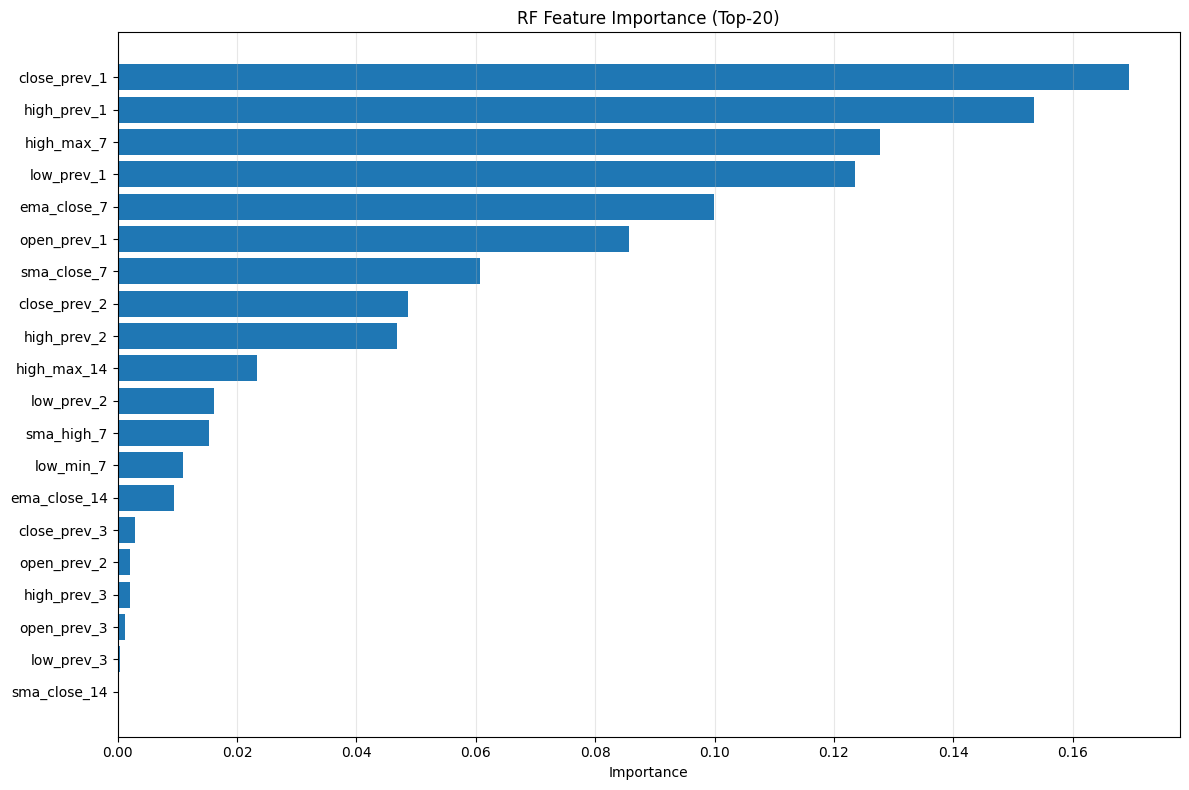

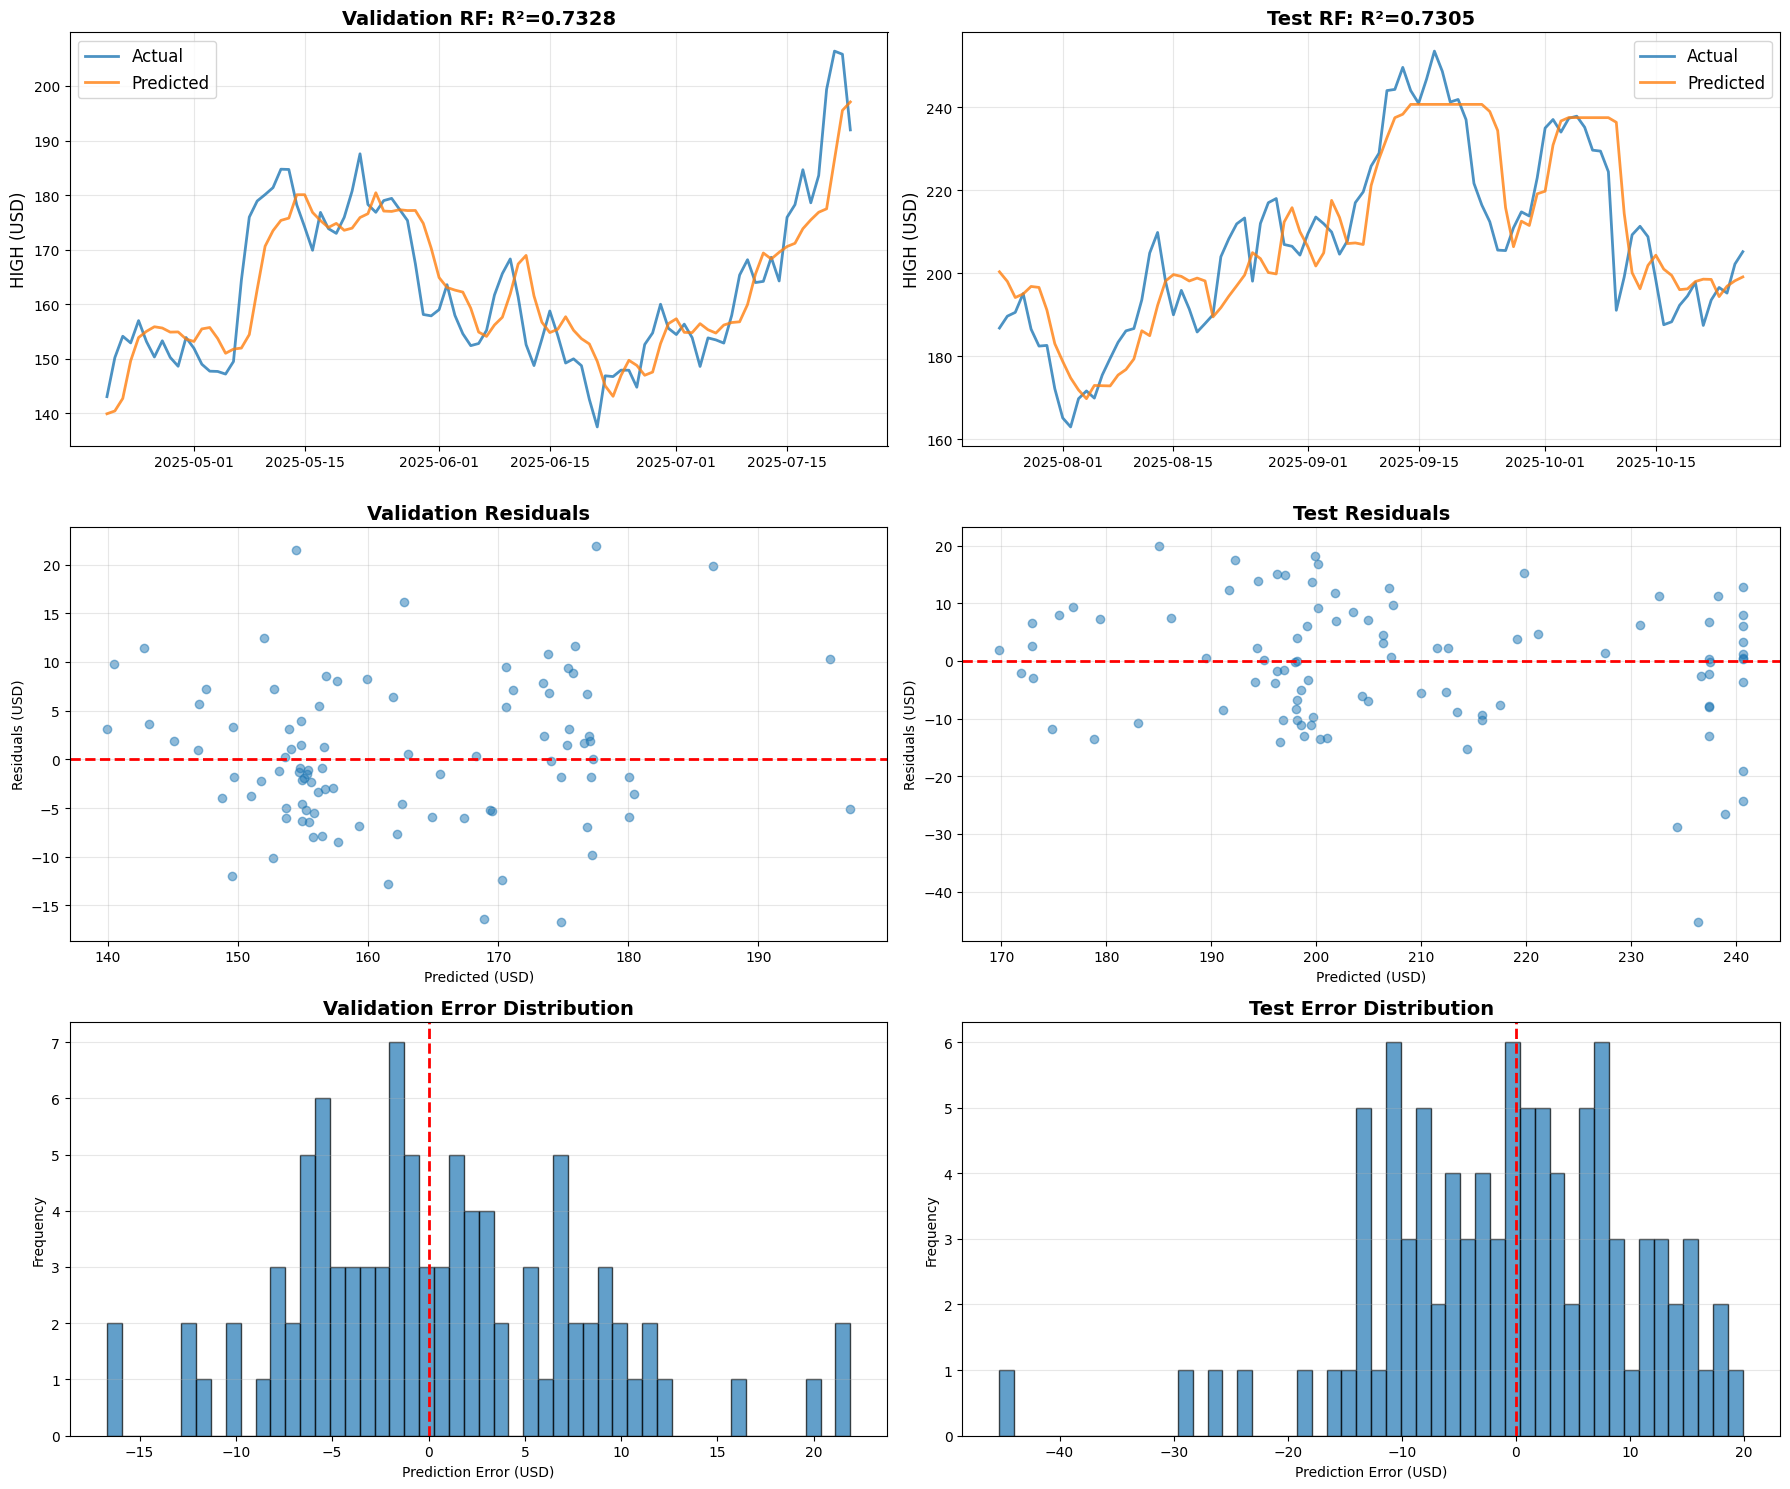


✓ Visualizations complete


In [8]:
# ============================================
# 7) MODEL A: RandomForest (baseline, conservative) – matches friend’s pattern
# ============================================
print("="*70); print("BASELINE – RANDOM FOREST (CONSERVATIVE)"); print("="*70)

rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=10, min_samples_split=50, min_samples_leaf=25,
    max_features='sqrt', max_samples=0.8, random_state=RANDOM_STATE, n_jobs=-1
)

print("\nTraining RF with TOP-20 features…")
rf_model.fit(X_train_sel, y_train)

y_tr_rf = rf_model.predict(X_train_sel)
y_va_rf = rf_model.predict(X_val_sel)
y_te_rf = rf_model.predict(X_test_sel)

rf_train = evaluate(y_train, y_tr_rf, "RF – Train")
rf_val   = evaluate(y_val,   y_va_rf, "RF – Validation")
rf_test  = evaluate(y_test,  y_te_rf, "RF – Test")

print("\n" + "="*70); print("OVERFITTING CHECK – RF"); print("="*70)
print(f"Train–Val R² gap:  {rf_train['r2'] - rf_val['r2']:.4f}")
print(f"Train–Test R² gap: {rf_train['r2'] - rf_test['r2']:.4f}")

# Feature importance (limited to selected features)
rf_imp = pd.DataFrame({'feature': selected_features, 'importance': rf_model.feature_importances_}) \
            .sort_values('importance', ascending=False)
print("\nFeature Importance (RF, Top-20):")
print(rf_imp)

plt.figure(figsize=(12, 8))
plt.barh(range(len(rf_imp)), rf_imp['importance'].values)
plt.yticks(range(len(rf_imp)), rf_imp['feature'].values)
plt.xlabel('Importance'); plt.title('RF Feature Importance (Top-20)'); plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()

plot_suite(y_val, y_va_rf, y_test, y_te_rf, timestamps_val, timestamps_test,
           f'Validation RF: R²={rf_val["r2"]:.4f}', f'Test RF: R²={rf_test["r2"]:.4f}')

# ============================================
# 8) MODEL B: LightGBM (Huber – robust, better for spikes)
# ============================================
print("="*70); print("IMPROVED – LIGHTGBM (HUBER LOSS)"); print("="*70)

lgb = LGBMRegressor(
    objective="huber",
    n_estimators=2000, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.8,
    num_leaves=63, reg_lambda=1.0, random_state=RANDOM_STATE
)

print("\nTraining LightGBM with TOP-20 features…")
# Note: tree models don't need scaling, but we're following the friend’s structure (using selected/scaled)
lgb.fit(X_train_sel, y_train, eval_set=[(X_val_sel, y_val)], verbose=False)

y_tr_lgb = lgb.predict(X_train_sel)
y_va_lgb = lgb.predict(X_val_sel)
y_te_lgb = lgb.predict(X_test_sel)

lgb_train = evaluate(y_train, y_tr_lgb, "LGBM – Train")
lgb_val   = evaluate(y_val,   y_va_lgb, "LGBM – Validation")
lgb_test  = evaluate(y_test,  y_te_lgb, "LGBM – Test")

print("\n" + "="*70); print("OVERFITTING CHECK – LGBM"); print("="*70)
print(f"Train–Val R² gap:  {lgb_train['r2'] - lgb_val['r2']:.4f}")
print(f"Train–Test R² gap: {lgb_train['r2'] - lgb_test['r2']:.4f}")

# LightGBM feature importance (gain-based)
try:
    lgb_imp = pd.DataFrame({
        'feature': selected_features,
        'importance': lgb.booster_.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False)
    print("\nFeature Importance (LGBM, Top-20):")
    print(lgb_imp.head(20))

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(lgb_imp.head(20))), lgb_imp.head(20)['importance'].values)
    plt.yticks(range(len(lgb_imp.head(20))), lgb_imp.head(20)['feature'].values)
    plt.xlabel('Gain'); plt.title('LGBM Feature Importance (Top-20)'); plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()
except Exception as e:
    print("LGBM importance not available:", e)

plot_suite(y_val, y_va_lgb, y_test, y_te_lgb, timestamps_val, timestamps_test,
           f'Validation LGBM: R²={lgb_val["r2"]:.4f}', f'Test LGBM: R²={lgb_test["r2"]:.4f}')

# ============================================
# 9) CHOOSE BEST & SAVE ARTIFACTS
# ============================================
def better(a, b, key="mae"):
    """Return name of better model by metric (lower is better)."""
    return "LGBM" if a[key] > b[key] else "RF"

best_name = better(rf_test, lgb_test, key="mae")
best_model = lgb if best_name == "LGBM" else rf_model

# Persist
joblib.dump(best_model, f"{MODEL_DIR}/solana_{best_name.lower()}_top20.pkl")
joblib.dump(scaler,     f"{MODEL_DIR}/solana_scaler_top20.pkl")
joblib.dump(selected_features, f"{MODEL_DIR}/solana_feature_columns_top20.pkl")

metadata = {
    "token": "SOL",
    "algorithm": "LightGBM-Huber" if best_name=="LGBM" else "RandomForest",
    "random_state": RANDOM_STATE,
    "n_features_selected": len(selected_features),
    "selected_features": selected_features,
    "train_date": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "rf_test": rf_test, "lgbm_test": lgb_test,
    "chosen": best_name
}
joblib.dump(metadata, f"{MODEL_DIR}/solana_model_metadata_top20.pkl")

print("\n" + "="*70)
print("✓ MODEL(S) SAVED!")
print("="*70)
print(f"Saved to: {MODEL_DIR}")
print(f"  - solana_{best_name.lower()}_top20.pkl")
print("  - solana_scaler_top20.pkl")
print("  - solana_feature_columns_top20.pkl")
print("  - solana_model_metadata_top20.pkl")

print("\nFINAL ASSESSMENT")
print("="*70)
def status(metrics):
    if metrics['r2'] > 0.75: return "EXCELLENT"
    if metrics['r2'] > 0.60: return "GOOD"
    if metrics['r2'] > 0.00: return "MARGINAL"
    return "FAILING"

print(f"\nRF Test → R²: {rf_test['r2']:.4f} | MAE: ${rf_test['mae']:.2f} | RMSE: ${rf_test['rmse']:.2f} | {status(rf_test)}")
print(f"LGBM Test → R²: {lgb_test['r2']:.4f} | MAE: ${lgb_test['mae']:.2f} | RMSE: ${lgb_test['rmse']:.2f} | {status(lgb_test)}")
print(f"\n✅ Chosen model: {best_name} (lower MAE on Test)")
print("\nNext steps:")
print("  1) Export prediction function to FastAPI")
print("  2) Containerize and deploy to Render")
print("  3) Connect Streamlit tab to your FastAPI /predict/solana")

IMPROVED – LIGHTGBM (HUBER LOSS)

Training LightGBM with TOP-20 features…
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2756
[LightGBM] [Info] Number of data points in the train set: 441, number of used features: 20
[LightGBM] [Info] Start training from score 169.260544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

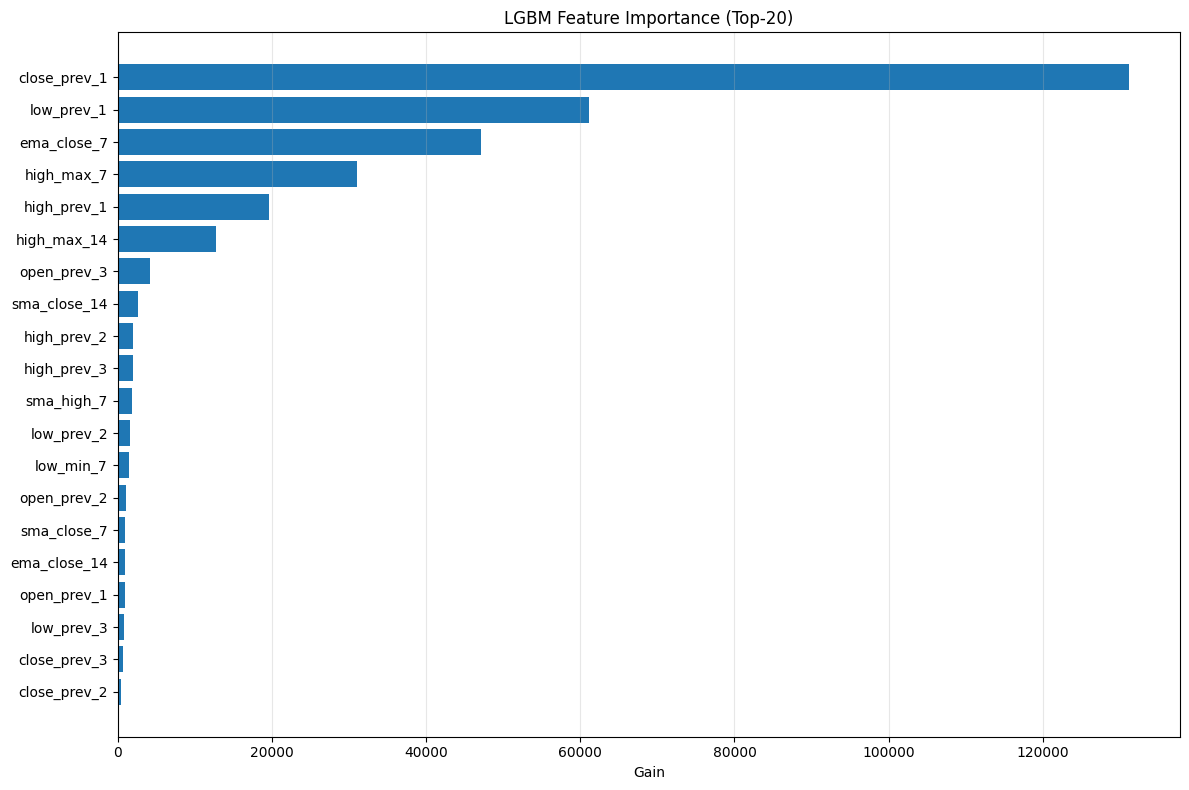

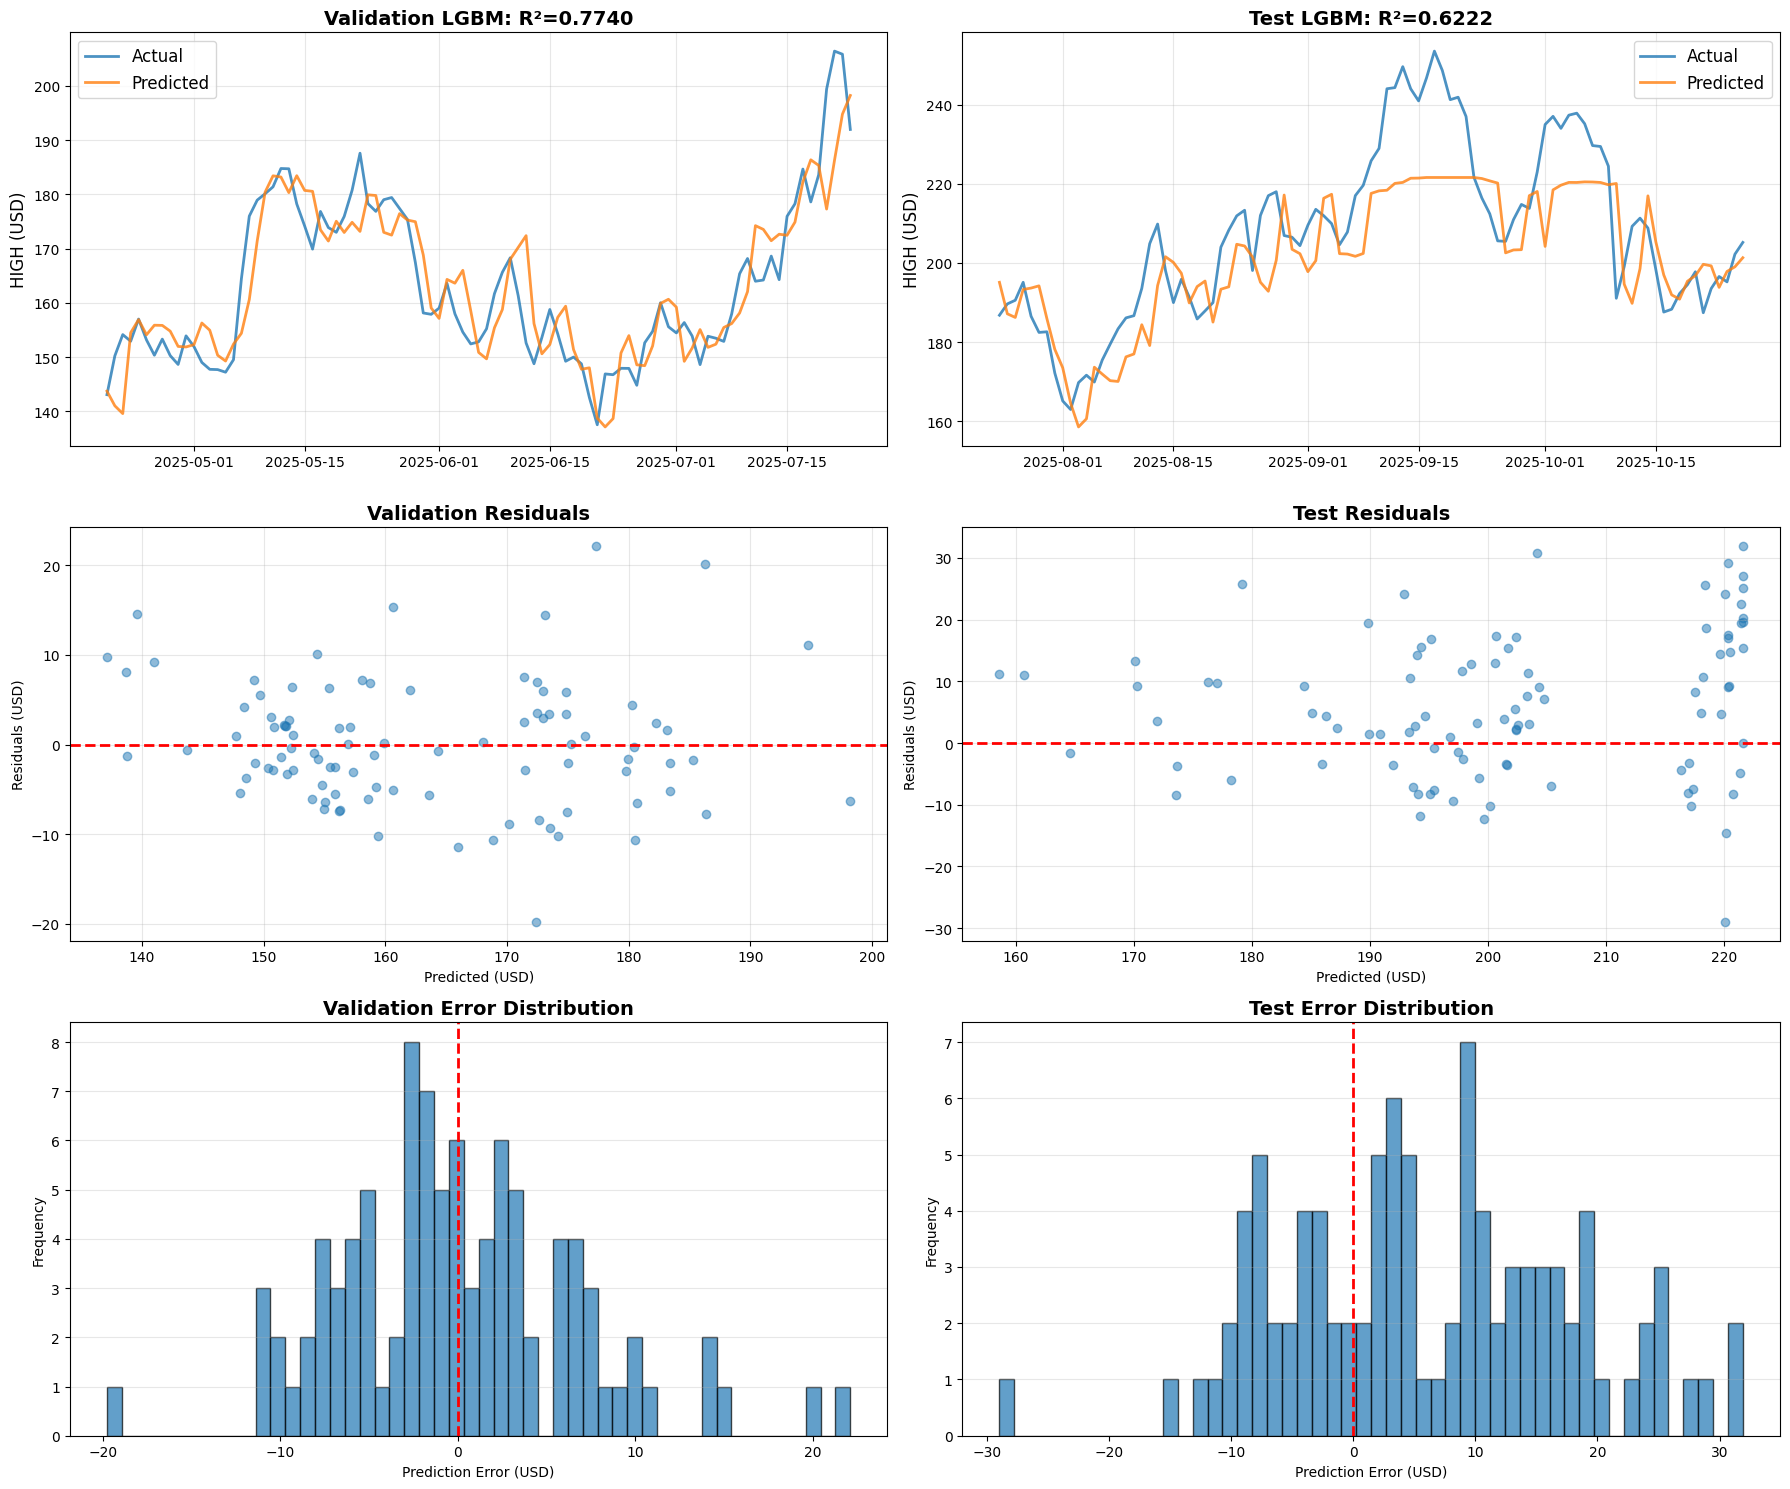


✓ Visualizations complete


In [10]:
# ============================================
# 8) MODEL B: LightGBM (Huber – robust, better for spikes)
# ============================================
print("="*70); print("IMPROVED – LIGHTGBM (HUBER LOSS)"); print("="*70)

lgb = LGBMRegressor(
    objective="huber",
    n_estimators=2000, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.8,
    num_leaves=63, reg_lambda=1.0, random_state=RANDOM_STATE
)

print("\nTraining LightGBM with TOP-20 features…")
# Note: tree models don't need scaling, but we're following the friend’s structure (using selected/scaled)
lgb.fit(X_train_sel, y_train, eval_set=[(X_val_sel, y_val)])

y_tr_lgb = lgb.predict(X_train_sel)
y_va_lgb = lgb.predict(X_val_sel)
y_te_lgb = lgb.predict(X_test_sel)

lgb_train = evaluate(y_train, y_tr_lgb, "LGBM – Train")
lgb_val   = evaluate(y_val,   y_va_lgb, "LGBM – Validation")
lgb_test  = evaluate(y_test,  y_te_lgb, "LGBM – Test")

print("\n" + "="*70); print("OVERFITTING CHECK – LGBM"); print("="*70)
print(f"Train–Val R² gap:  {lgb_train['r2'] - lgb_val['r2']:.4f}")
print(f"Train–Test R² gap: {lgb_train['r2'] - lgb_test['r2']:.4f}")

# LightGBM feature importance (gain-based)
try:
    lgb_imp = pd.DataFrame({
        'feature': selected_features,
        'importance': lgb.booster_.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False)
    print("\nFeature Importance (LGBM, Top-20):")
    print(lgb_imp.head(20))

    plt.figure(figsize=(12, 8))
    plt.barh(range(len(lgb_imp.head(20))), lgb_imp.head(20)['importance'].values)
    plt.yticks(range(len(lgb_imp.head(20))), lgb_imp.head(20)['feature'].values)
    plt.xlabel('Gain'); plt.title('LGBM Feature Importance (Top-20)'); plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3); plt.tight_layout(); plt.show()
except Exception as e:
    print("LGBM importance not available:", e)

plot_suite(y_val, y_va_lgb, y_test, y_te_lgb, timestamps_val, timestamps_test,
           f'Validation LGBM: R²={lgb_val["r2"]:.4f}', f'Test LGBM: R²={lgb_test["r2"]:.4f}')

In [12]:
# ============================================
# 9) CHOOSE BEST & SAVE ARTIFACTS
# ============================================
def better(a, b, key="mae"):
    """Return name of better model by metric (lower is better)."""
    return "LGBM" if a[key] > b[key] else "RF"

best_name = better(rf_test, lgb_test, key="mae")
best_model = lgb if best_name == "LGBM" else rf_model

# Persist
joblib.dump(best_model, f"{MODEL_DIR}/solana_{best_name.lower()}_top20.pkl")
joblib.dump(scaler,     f"{MODEL_DIR}/solana_scaler_top20.pkl")
joblib.dump(selected_features, f"{MODEL_DIR}/solana_feature_columns_top20.pkl")

metadata = {
    "token": "SOL",
    "algorithm": "LightGBM-Huber" if best_name=="LGBM" else "RandomForest",
    "random_state": RANDOM_STATE,
    "n_features_selected": len(selected_features),
    "selected_features": selected_features,
    "train_date": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "rf_test": rf_test, "lgbm_test": lgb_test,
    "chosen": best_name
}
joblib.dump(metadata, f"{MODEL_DIR}/solana_model_metadata_top20.pkl")

print("\n" + "="*70)
print("✓ MODEL(S) SAVED!")
print("="*70)
print(f"Saved to: {MODEL_DIR}")
print(f"  - solana_{best_name.lower()}_top20.pkl")
print("  - solana_scaler_top20.pkl")
print("  - solana_feature_columns_top20.pkl")
print("  - solana_model_metadata_top20.pkl")

print("\nFINAL ASSESSMENT")
print("="*70)
def status(metrics):
    if metrics['r2'] > 0.75: return "EXCELLENT"
    if metrics['r2'] > 0.60: return "GOOD"
    if metrics['r2'] > 0.00: return "MARGINAL"
    return "FAILING"

print(f"\nRF Test → R²: {rf_test['r2']:.4f} | MAE: ${rf_test['mae']:.2f} | RMSE: ${rf_test['rmse']:.2f} | {status(rf_test)}")
print(f"LGBM Test → R²: {lgb_test['r2']:.4f} | MAE: ${lgb_test['mae']:.2f} | RMSE: ${lgb_test['rmse']:.2f} | {status(lgb_test)}")
print(f"\n✅ Chosen model: {best_name} (lower MAE on Test)")
print("\nNext steps:")
print("  1) Export prediction function to FastAPI")
print("  2) Containerize and deploy to Render")
print("  3) Connect Streamlit tab to your FastAPI /predict/solana")


✓ MODEL(S) SAVED!
Saved to: /content/drive/MyDrive/AdvMLAT3/models
  - solana_rf_top20.pkl
  - solana_scaler_top20.pkl
  - solana_feature_columns_top20.pkl
  - solana_model_metadata_top20.pkl

FINAL ASSESSMENT

RF Test → R²: 0.7305 | MAE: $8.61 | RMSE: $11.15 | GOOD
LGBM Test → R²: 0.6222 | MAE: $10.63 | RMSE: $13.20 | GOOD

✅ Chosen model: RF (lower MAE on Test)

Next steps:
  1) Export prediction function to FastAPI
  2) Containerize and deploy to Render
  3) Connect Streamlit tab to your FastAPI /predict/solana
